# AIF_sprint11-12-NN　ニューラルネットワークの基本事項の説明と実装

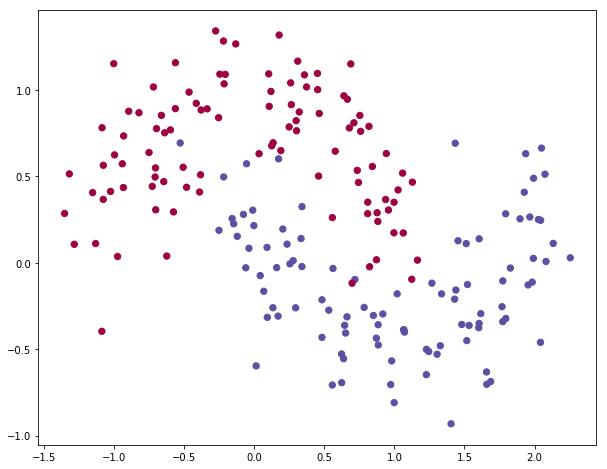

In [2]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)


# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    print(type(np.c_[xx.ravel(), yy.ravel()]))
    print(xx.ravel())
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()], params)
    # 予測値から予測したクラスに変換する
    print(Z.shape)
    Z = Z[: ,0]
    Z[Z>0.5] = 0
    Z[Z>0] = 1
    
    print(Z.shape)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

# Generate a dataset and plot it
np.random.seed(0)
# X, y = sklearn.datasets.make_moons(200, noise=0.50)
X, y = sklearn.datasets.make_moons(200, noise=0.20)

plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

### y作成

y をone-hot表現に変更する。

In [3]:
# 元のyデータは１列であるが、出力層のユニットを２個にしているため、２個分の出力データ配列（２列）を作成する  
#つまり、片方の入力が１の時、もう片方は０である入力データにする
def convert_onehot(y):
    y1 = y.copy()
    y1[y==0]=1
    y1[y==1]=0
    return np.array([y,y1]).T
y_onehot = convert_onehot(y)

## 活性化関数





### 活性化関数の説明

活性化関数とは（入力層以外の層の）ユニットにおいて、入力に対してどのような出力を出すかを規定する関数である。  
実際のニューロンの入出力の様子を模擬している。  
非線形の活性化関数を用いることによって線形関数では表現できない問題に対しても表現できるようになる。

### 活性化関数の実装

#### (1)ステップ関数  
特徴：プラスの入力があれば固定値（１）を出力する

In [4]:
def step(z):
    a = z.copy()
    a[0<=a]=1
    a[a<0]=0    
    return a

#### (2)シグモイド関数  
特徴：出力が０〜１の間の連続値をとる。入力値が０の前後で変化する時に出力値が最も大きく変化する。

In [5]:
def sigmoid(z):
     return 1/(1+np.exp(-z))

#### (3)ReLU  
特徴：入力がプラスの値の場合、そのままの値を出力する。

In [6]:
def ReLU(z):
    a = z.copy()
    a[a<0]=0
    return a

#### (4)tanh  
特徴：出力が−１〜１の値をとる。入力がマイナスの場合にマイナスの出力を出す点が他の関数と大きく異なる。

In [7]:
def tanh(X):
    return np.tanh(X)

#### 活性化関数の使い分け

・２値分類に対して：シグモイド関数が良い（出力を該当確率として扱う）  
・３種以上の分類に対して：ソフトマックス関数が良い （出力を該当確率として扱う、また、代わりに恒等関数でも良い）  
・多層ネットワークの隠れ層に対して：ReLU関数が良い（勾配消失対策として）

## 出力層

### 出力関数（ソフトマックス関数）の実装

In [8]:
def softmax(X):
    return np.exp(X) / np.sum(np.exp(X), axis=1)[:, np.newaxis]

## フォワードプロパゲーション

### フォワードプロパゲーションの実装

In [9]:
# フォワードプロパゲーション（３層用、隠れ層活性化関数：tanh、出力層活性化関数：softmax）
# X：入力、b1・b2：バイアス
def predict(X, params):
    z1 = np.dot(X, params['W1']) + params['b1']
    a1 = tanh(z1)
    z2 = np.dot(a1, params['W2']) + params['b2']
    y_pred = softmax(z2)
    
    return y_pred

### フォワードプロパゲーションの説明

フォワードプロパゲーションとはネットワークに入力を入れて出力を得ることである。  


## コスト関数

### コスト関数の実装

In [10]:
def cost(y, y_pred, params, lam=0.01):
    # データサイズ　＝ yの行数
    data_size = y.shape[0]
    
    #  重みの値の二乗和を計算（正則化項用） 
    #  params辞書から全てのキーと値を取り出して、キーにWが含まれるもの（今回はW1,W2）の値を二乗して合計値を求める
    weight_sum = sum([np.sum(matrix**2) for key, matrix in params.items() if "W" in key])
    
    #正則化項
    reg_term = (lam /2) * (weight_sum)
    
    # クロスエントロピー誤差関数　（y_predは０になりえるので -inf にならないためにすごく小さい補正値を入れる）
    # 全要素合計
    cross_entorpy = -np.sum(y * np.log(y_pred + 1e-7))
    cost = (cross_entorpy + reg_term) / data_size
    return cost

In [11]:
# 正答率を算出する
def accuracy_score(y, y_pred):
    # 出力値が0.5以上であれば、そちらだと判断したと解釈する
    # 条件判定してTrue/False化し、True(1)の合計を求め、データサイズで割ると正答率が出る
    score = np.sum([(y * y_pred)>=0.5]) / y.shape[0]    
    return score

## バックプロパゲーション









### バックプロパゲーション関数の説明

コスト関数を各変数の値で偏微分して勾配を求める。  
その際、出力層から入力層へと遡りながら求めていくことで、連鎖率を利用して、計算量を減らすことができる。

### バックプロパゲーション関数のワークシート
紙で提出済み

### 数値微分とバックプロパゲーション

バックプロパゲーションを用いる理由は、数値微分よりも計算量が少なくて済むからである。  
パックプロパゲーションでは、微分の連鎖律を用いることで、他の箇所の微分計算結果を利用することができ、  
計算量を減らすことができる。  
一方、数値微分は対象となるパラメータの値を微小に変えた場合のコスト関数の値を計算する必要がある。  
そのためには、パラメータを微小に変えた場合のネットワークの出力が必要となるため、再度フォワードプロパゲーション  
を行う必要が発生する。よって、結合の数が多いネットワーク程、数値微分の計算量の差はバックプロパゲーションに対し  
てより多くなっていく。

### バックプロパゲーション関数の実装

In [12]:
def back_propagation(X, y, params, alpha=0.01, lam=0.1):
        # 予測値計算
        y_pred = predict(X, params) 
        # backpropagation
        z1 = np.dot(X, params['W1']) + params['b1']
        a1 = tanh(z1)
        delta3 = y_pred - y
        delta2 = (1 - tanh(z1) ** 2) * np.dot(delta3, params['W2'].T)
        #パラメータ更新
        params['W2'] -= alpha * (np.dot(a1.T, delta3) + lam * params['W2'] )
        params['b2'] -= alpha * (delta3.sum(axis=0)[:, np.newaxis].T  )  #keepdims = True が使えるのでは？
        params['W1'] -= alpha * (np.dot(X.T, delta2) + lam * params['W1'] )
        params['b1'] -= alpha * (delta2.sum(axis=0)[:, np.newaxis].T  )  #keepdims = True が使えるのでは？
        return params

### 最急降下法

In [13]:
from sklearn.model_selection import train_test_split

def gradient_descent(X, y, iteration=1000, alpha=0.01, lam=0.1, learning_mode=0):
    """
    learning mode 
    0: バッチ学習
    1:　ミニバッチ学習
    2:　オンライン学習
    """
    # ユニット数の設定
    num_unit = 10 #隠れ層のユニット数
    num_class = 2 #出力層のユニット数
    # mini-batch size
    mini_batch_size = 20
    
    # 訓練とテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=0)
    # yデータ整形（２列化）
    y_train = convert_onehot(y_train)
    y_test = convert_onehot(y_test)

    
    # ユニット用パラメータ初期化
    # W1,W2は正規分布（平均０、分散１）の乱数で初期化、バイアスb1,b2は０で初期化
    params = {
        'W1': np.random.randn(X_train.shape[1], num_unit) * 0.1, #W1は入力層から隠れ層への結合荷重
        'b1': np.zeros([1, num_unit]),
        'W2': np.random.randn(num_unit, num_class) * 0.1, #W2は隠れ層から出力層へのへ結合荷重
        'b2': np.zeros([1, num_class])
    }

    # 訓練結果格納用
    past_costs = []
    past_accuracy = []
    # valid結果格納用
    valid_past_costs = []
    valid_past_accuracy = []
  
    #バッチサイズ
    if learning_mode == 0: 
        batch_size = X_train.shape[0] #バッチ学習は全データ使用
    elif learning_mode == 1:
        batch_size = mini_batch_size #ミニバッチ学習はデータの一部を使用
    elif learning_mode == 2:
        batch_size = 1 #オンライン学習は１データを使用
    
    # 今回のデータサイズ
    data_size = X_train.shape[0]
    
    #####  学習実施 ##########################################################
    for i in range(iteration):
        # どのデータを使うかを決め、取り出す
        choice_index = np.random.choice(data_size, batch_size)
        X_choice = X_train[choice_index]
        y_choice = y_train[choice_index]
        
        #学習データに対する予測
        y_pred_train =  predict(X_train, params) 
        
        # 学習データに対する正答率とコストを算出
        past_accuracy.append(accuracy_score(y_train, y_pred_train))
        past_costs.append(cost(y_train, y_pred_train, params, lam))
        
        #テストデータに対する予測
        y_pred_valid =  predict(X_test, params)
        
        # テストデータの正答率とコストを算出
        valid_past_accuracy.append(accuracy_score(y_test, y_pred_valid))
        valid_past_costs.append(cost(y_test, y_pred_valid, params, lam))

        # パラメータ更新
        params = back_propagation(X_choice, y_choice, params, alpha, lam)
        
    return params, past_costs, past_accuracy, valid_past_costs, valid_past_accuracy

### 学習方法の説明



・バッチ学習：手元にあるデータ全てを使ってフィードフォワードを行い、その結果をもとにバックプロパゲーションを１回行う方法  
・オンライン学習：手元にあるデータの中から1つを選び出してフィードフォワードを行い、その結果をもとにバックプロパゲーションを  
　１回行うという学習方法  
・ミニバッチ学習：手元にあるデータの一部を使ってフィードフォワードを行い、その結果をもとにバックプロパゲーションを１回行う  
　という手順を繰り返す学習方法  
 
上記の各手法の違いとしては、以下の点が挙げられる。  
・バッチ学習は全データの情報を利用するため他の学習法に比べて過学習しにくいが、その反面、全データを使うためデータ数が多いと  
　学習１回当たりの計算量が多くなってしまう  
・オンライン学習は、データ１個の結果で学習を行うため各データの影響を強く受ける。また、学習するデータの順番によって結果が異なる。  
　そのため、他の学習方法に比べて、うまく行く可能性もあるが、うまくいかない可能性もあるという確率的要素が強い手法である。   
・ミニバッチ学習は、データ数が多い場合に採用すべき現実的手法であるが、適切なデータサイズを決める手間が発生する。

### 学習曲線のプロット

In [14]:
def plot_learning_curve(X, y, iterations, alpha, lam=0.01, metrics='cost', learning_mode=0): 
    
    _, past_costs, past_accuracy, valid_past_costs, valid_past_accuracy = gradient_descent(X, y, \
                                                                                           iterations, alpha,\
                                                                                           lam, learning_mode)
    
    if metrics == 'cost':
        plt.plot(np.array(list(range(iterations))), np.array(past_costs), color='r',label='train')
        plt.plot(np.array(list(range(iterations))), np.array(valid_past_costs),label='test')
        plt.ylabel("cost", fontsize=15)
        print("last train cost is {}".format(past_costs[-1]))
        print("last test cost is {}".format(valid_past_costs[-1]))
    else:
        plt.plot(np.array(list(range(iterations))), np.array(past_accuracy), color='r',label='train')
        plt.plot(np.array(list(range(iterations))), np.array(valid_past_accuracy),label='test')
        plt.ylabel("accuracy", fontsize=15)
        print("last train accuracy is {}".format(past_accuracy[-1]))
        print("last test accuracy is {}".format(valid_past_accuracy[-1]))
        plt.ylim(-0.05, 1.05)
    
    plt.legend()
    plt.title('Learning Curve', fontsize=20)
    
    plt.xlabel("iteration", fontsize=15)
    

### 正則化項目を入れる


last train cost is 0.3423967264951067
last test cost is 0.456176487588824


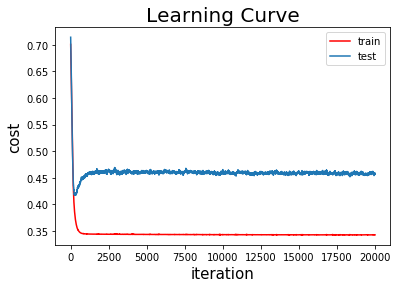

In [15]:
plot_learning_curve(X, y, 20000, 0.0002, 2, 'cost', learning_mode=0)

last train cost is 0.35373020064857147
last test cost is 0.36568521400224124


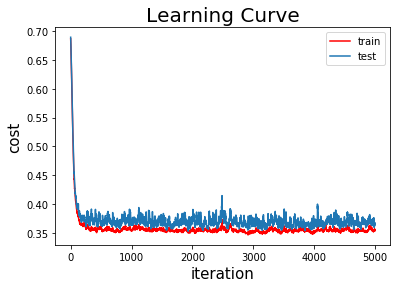

In [16]:
plot_learning_curve(X, y, 5000, 0.005, 1, 'cost', learning_mode=1)

last train cost is 0.3273452685920559
last test cost is 0.34477090519091985


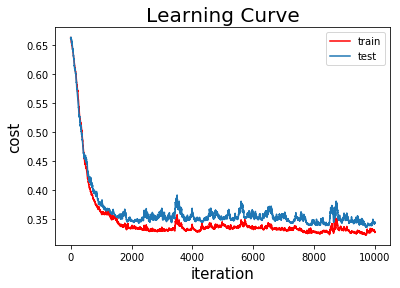

In [17]:
plot_learning_curve(X, y, 10000, 0.01, 0.05, 'cost', learning_mode=2)

last train accuracy is 0.85
last test accuracy is 0.825


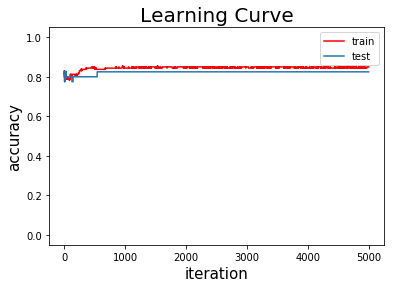

In [18]:
plot_learning_curve(X, y, 5000, 0.0002, 2, 'acc', learning_mode=0)

last train accuracy is 0.84375
last test accuracy is 0.85


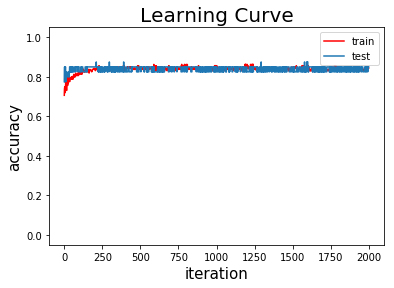

In [19]:
plot_learning_curve(X, y, 2000, 0.005, 1.5, 'acc', learning_mode=1)

last train accuracy is 0.875
last test accuracy is 0.775


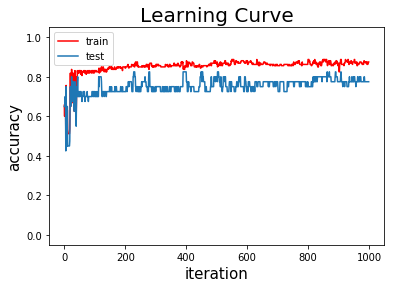

In [20]:
plot_learning_curve(X, y, 1000, 0.05, 0.01, 'acc', learning_mode=2)

## ハイパーパラメータ

### ハイパーパラメータの初期化

隠れ層のユニット数、学習率、正則化は以下の初期値から開始する  
・隠れ層のユニット数：２  
・学習率：0.01  
・正則化：0.1

・ハイパーパラメータの設定方針 
１、各パラメータの初期値を小さい値に設定する。  
２、結果を見て、精度は良いがコストが高い場合は正則化の値を増やしていく。  
　　また、試行回数が進むごとに精度が良くなるが最終的な精度がまだ不十分な場合、その改善具合が非常に緩やかであれば学習率を大きくし、  
　　逆に十分な勢いがあればまずは試行回数を増やしてみる。  
３、これらをいくら試しても精度が不十分であれば、隠れ層ユニット数を増やしてみる。

### 決定境界の実装

<class 'numpy.ndarray'>
[-1.85462041 -1.84462041 -1.83462041 ...  2.72537959  2.73537959
  2.74537959]
(151208, 2)
(151208,)


0.855

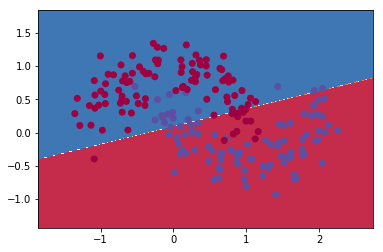

In [21]:

params = gradient_descent(X, y, iteration=1000, alpha=0.001, lam=0.0, learning_mode=0)[0]
plot_decision_boundary(predict)
y_pred2 =  predict(X, params)
y2 = convert_onehot(y)
accuracy_score(y2, y_pred2)
